In [72]:
FILE_SUFFIX = 'RANDOM_FOREST_NO_LEAKAGE2'

# Load Data

In [73]:
import pandas as pd
import numpy as np

data = pd.read_csv('data_balanced_processed.csv', encoding='latin-1')
data.head()

,drummer,session,id,style,simplified_style,bpm,beat_type,time_signature,midi_filename,audio_filename,...,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_flatness_mean,spectral_flatness_std,tempogram_mean,tempogram_std,spectrum_filename
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,funk,138,1,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,...,0.056157,5608.665252,2501.480437,4647.658427,941.263597,0.090434,0.124045,0.294583,0.171183,drummer1/eval_session/1_funk-groove1_138_beat_...
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,funk,102,1,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,...,0.062846,7204.425221,3338.747216,5212.773742,1194.914650,0.148189,0.143111,0.267859,0.234713,drummer1/eval_session/10_soul-groove10_102_bea...
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,funk,105,1,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,...,0.061557,6172.809370,3874.975566,4711.894615,1483.392124,0.116454,0.132516,0.238676,0.153792,drummer1/eval_session/2_funk-groove2_105_beat_...
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,funk,86,1,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,...,0.053402,5704.099294,3309.100713,5098.568553,1251.293005,0.101191,0.128717,0.149444,0.144291,drummer1/eval_session/3_soul-groove3_86_beat_4...
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,funk,80,1,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,...,0.046688,8042.372855,3504.921958,5396.953176,999.442925,0.181278,0.149775,0.115379,0.128980,drummer1/eval_session/4_soul-groove4_80_beat_4...


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   drummer                  1200 non-null   object 
 1   session                  1200 non-null   object 
 2   id                       1200 non-null   object 
 3   style                    1200 non-null   object 
 4   simplified_style         1200 non-null   object 
 5   bpm                      1200 non-null   int64  
 6   beat_type                1200 non-null   int64  
 7   time_signature           1200 non-null   object 
 8   midi_filename            1200 non-null   object 
 9   audio_filename           1200 non-null   object 
 10  duration                 1200 non-null   float64
 11  split                    1200 non-null   object 
 12  start                    1200 non-null   float64
 13  end                      1200 non-null   float64
 14  times_sampled           

In [75]:
from sklearn.model_selection import GroupShuffleSplit
group_shuffle_rnd_state = 8698

In [76]:
# prevent data leakage by grouping splits by audio_filename
groups = data['audio_filename']
gss = GroupShuffleSplit(n_splits=5, train_size=0.7, random_state=group_shuffle_rnd_state)
for train_indices, test_indices in gss.split(X=data, groups=groups):
    #GroupShuffleSplit.split() returns a tuple instead of Numpy.nparray when used outside of a for loop somehow. So I guess I need to fill this loop with code...
    useless_variable = None

# create dataframe from group split indices and shuffle the train dataframe
data_train = data.iloc[train_indices].sample(frac=1.0, random_state=42)
data_test = data.iloc[test_indices]

# check for data leakage
print('Data leakage =', data_train['audio_filename'].isin(data_test['audio_filename']).any())

# check genre distribution
print("\nTrain data genre distribution")
print(data_train.simplified_style.value_counts(normalize=True))

print("\nRemaining data genre distribution")
print(data_test.simplified_style.value_counts(normalize=True))

Data leakage = False

Train data genre distribution
simplified_style
latin     0.169082
rock      0.167874
funk      0.167874
hiphop    0.166667
jazz      0.166667
pop       0.161836
Name: proportion, dtype: float64

Remaining data genre distribution
simplified_style
pop       0.177419
jazz      0.166667
hiphop    0.166667
funk      0.163978
rock      0.163978
latin     0.161290
Name: proportion, dtype: float64


In [77]:
from sklearn.model_selection import train_test_split

# check the distribution after the split
print(data_train.shape, data_test.shape)
print("Train data share: ", data_train.shape[0] / data.shape[0])
print("Test data share: ", data_test.shape[0] / data.shape[0])

(828, 38) (372, 38)
Train data share:  0.69
Test data share:  0.31


# Split labels and features

In [78]:
def split_labels_and_features(data):
    # seperate labels
    y = data.simplified_style
    # seperate data
    X = data
    print(X.columns)
    # drop unnecessary data
    X = X.drop(columns=["drummer", "session", "id", 'beat_type', "midi_filename", "audio_filename", "style", "simplified_style", "split", "spectrum_filename"])
    # time signature would be a nice feature, but they are 99% in 4/4. We might as well drop this column to pevent overfitting
    X = X.drop(columns=["time_signature"])
    # The model should be able to predict a genre independent of duration so it should be dropped.
    # But duration also is an influence in some of the extracted audio features too. So i'm unsure if this could be benefcial to the interpretation of the extracted audio features.
    # lets keep it for now
    X = X.drop(columns=["duration", "start", "end", "times_sampled", "oversampling_ratio", "possible_samples"])
    return X, y

In [79]:
X_train, y_train = split_labels_and_features(data_train)
X_test, y_test = split_labels_and_features(data_test)

print(y_train)
print(X_train.columns)

Index(['drummer', 'session', 'id', 'style', 'simplified_style', 'bpm',
       'beat_type', 'time_signature', 'midi_filename', 'audio_filename',
       'duration', 'split', 'start', 'end', 'times_sampled',
       'possible_samples', 'oversampling_ratio', 'onset_env_mean',
       'onset_env_std', 'mfcc_mean', 'mfcc_std', 'spectral_flux_mean',
       'spectral_flux_std', 'spectral_contrast_mean', 'spectral_contrast_std',
       'tonnetz_mean', 'tonnetz_std', 'rms_mean', 'rms_std',
       'spectral_centroid_mean', 'spectral_centroid_std',
       'spectral_bandwidth_mean', 'spectral_bandwidth_std',
       'spectral_flatness_mean', 'spectral_flatness_std', 'tempogram_mean',
       'tempogram_std', 'spectrum_filename'],
      dtype='object')
Index(['drummer', 'session', 'id', 'style', 'simplified_style', 'bpm',
       'beat_type', 'time_signature', 'midi_filename', 'audio_filename',
       'duration', 'split', 'start', 'end', 'times_sampled',
       'possible_samples', 'oversampling_ratio', '

In [80]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Random Forest

In [81]:
import pickle
import os

path_data = os.path.join('..', 'data')
print(path_data)

def grid_search_pickling_path(prefix: str, dictionary: dict):
    dict_string = str(dictionary).replace(":", "").replace("'", "").replace("{", "").replace("}", "").replace(" ", "")
    filename = f'{prefix}_grid_search-{dict_string}.pkl'
    return os.path.join(path_data, filename)

..\data


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def perform_and_plot_RNDForest_grid_search(parameters: dict, train_data, train_labels):
    filepath = grid_search_pickling_path(FILE_SUFFIX, parameters)
    try:
        with open(filepath, 'rb') as file:
            grid_search = pickle.load(file)
        print(f"Loaded GridSearchCV from {filepath}\n with best params: {grid_search.best_params_}")
    except:
        print(f"Found no GridSearchCV at {filepath}. Calculating...")

        model = RandomForestClassifier(random_state=42)
        
        # Perform grid search
        grid_search = GridSearchCV(model, parameters, verbose=0, scoring='accuracy', cv=5)
        grid_search.fit(train_data, train_labels)
        
        with open(filepath, 'wb') as file:
            pickle.dump(grid_search, file)
    
    # Collect grid search results
    cv_results = grid_search.cv_results_
    mean_test_scores = cv_results['mean_test_score']
    params = cv_results['params']

    # Prepare data for plotting
    # Prepare data for plotting
    scores_array = np.array(mean_test_scores).reshape(
        len(parameters['max_depth']),
        len(parameters['min_samples_leaf']),
        len(parameters['n_estimators'])
    )

    # Create a line plot for each n_estimators
    fig, ax = plt.subplots(figsize=(10, 6))

    for k, n_estimators in enumerate(parameters['n_estimators']):
        scores_for_n_estimators = scores_array[:, :, k].T
        for i, min_samples_leaf in enumerate(parameters['min_samples_leaf']):
            ax.plot(parameters['max_depth'], scores_for_n_estimators[i], label=f'n_estimators: {n_estimators}, min_samples_leaf: {min_samples_leaf}',
                    marker='o', linestyle='--')

    ax.set_title('Grid Search Results')
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Mean Test Score')
    ax.legend(loc='best')

    plt.show()
    
    return grid_search


Loaded GridSearchCV from ..\data\RANDOM_FOREST_NO_LEAKAGE2_grid_search-max_depth[30,40,50,60,70],min_samples_leaf[2,3,4,5],n_estimators[50,100,150,200].pkl
 with best params: {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 150}


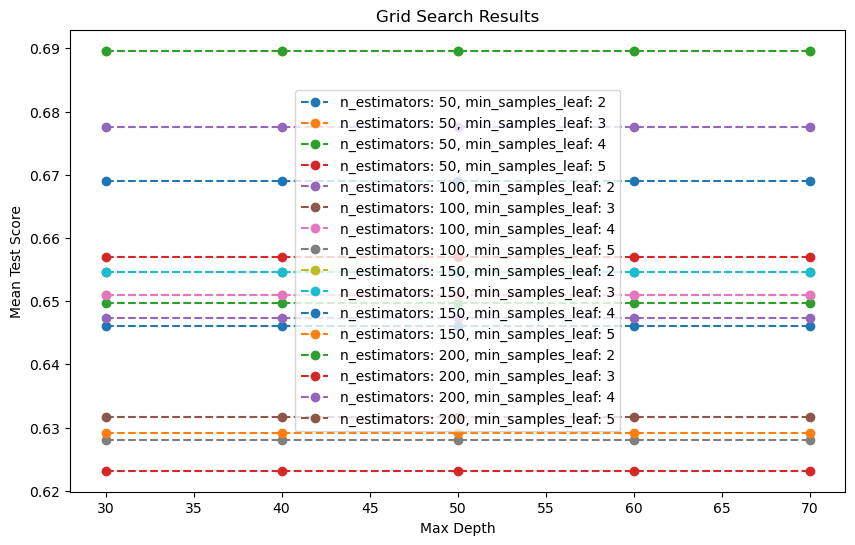

{'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 150} 0.6896239503468419


In [83]:
prefixed_parameters = {"max_depth": [30, 40, 50, 60, 70],
                        "min_samples_leaf": [2, 3, 4, 5],
                        "n_estimators":[50, 100, 150, 200]}

grid_search = perform_and_plot_RNDForest_grid_search(prefixed_parameters, X_train, y_train)
best_params = grid_search.best_params_
print(best_params, grid_search.best_score_)

In [84]:
n_estimators = best_params["n_estimators"]
max_depth = best_params["max_depth"]
min_samples_leaf = best_params["min_samples_leaf"]

In [85]:
# Initialize the base classifier
random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

# Train the model
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=150,
                       random_state=42)

### Evaluation

In [86]:
y_pred = random_forest.predict(X_test)

#### helper methods

In [87]:
from sklearn.metrics import classification_report, hamming_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model2(true_classes, predicted_classes):
    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

    # Hamming Loss
    h_loss = hamming_loss(true_classes, predicted_classes)
    print("Hamming Loss:", h_loss)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return report, h_loss

In [88]:
# Convert the classification report to a markdown table
def convert_to_markdown(report, hamming_loss, image_path=None, file_suffix=FILE_SUFFIX):
    lines = report.strip().split('\n')
    headers = lines[0].split()
    table = "| " + " | ".join(headers) + " |\n"
    table += "| " + " | ".join(['---'] * len(headers)) + " |\n"
    
    for line in lines[1:]:
        row = " | ".join(line.split())
        table += "| " + row + " |\n"
    
    markdown_content = f"# Classification Report for {file_suffix}\n\n"
    markdown_content += f"__Hamming Loss__ = {hamming_loss}\n\n{table}\n"
    
    if image_path:
        markdown_content += f"\n![Image]({image_path})\n"
    
    return markdown_content

def save_evaluation(report, h_loss, file_suffix=FILE_SUFFIX):
    eval_path = os.path.join('..', 'evaluation')
    conf_matrix_path = os.path.join(eval_path, 'images', 'confusion_matrix_' + file_suffix + '.png')
    markdwon_path = os.path.join(eval_path, 'markdown', 'classification_report_' + file_suffix + '.md')
    plt.savefig(conf_matrix_path)
    #plt.close()

    # Generate markdown content
    markdown_content = convert_to_markdown(report, h_loss, conf_matrix_path, file_suffix=file_suffix)

    # Write to a markdown file
    with open(markdwon_path, "w") as file:
        file.write(markdown_content)

#### feature importance

In [89]:
# create a dataframe with the name of a feature and its feature importance
def get_feature_importance_df(model, X):
    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    return feature_importance_df

get_feature_importance_df(random_forest, X_train)

,Feature,Importance
0,bpm,0.115040
4,mfcc_std,0.061749
12,rms_std,0.057044
5,spectral_flux_mean,0.054584
7,spectral_contrast_mean,0.051220
8,spectral_contrast_std,0.051109
2,onset_env_std,0.050301
1,onset_env_mean,0.048223
15,spectral_bandwidth_mean,0.047153
13,spectral_centroid_mean,0.046490


In [90]:
y_pred = label_encoder.transform(y_pred)

Classification Report:
               precision    recall  f1-score   support

        funk       0.56      0.39      0.46        61
      hiphop       0.45      0.56      0.50        62
        jazz       0.67      0.58      0.62        62
       latin       0.37      0.45      0.41        60
         pop       0.45      0.30      0.36        66
        rock       0.41      0.54      0.47        61

    accuracy                           0.47       372
   macro avg       0.49      0.47      0.47       372
weighted avg       0.49      0.47      0.47       372

Hamming Loss: 0.5295698924731183


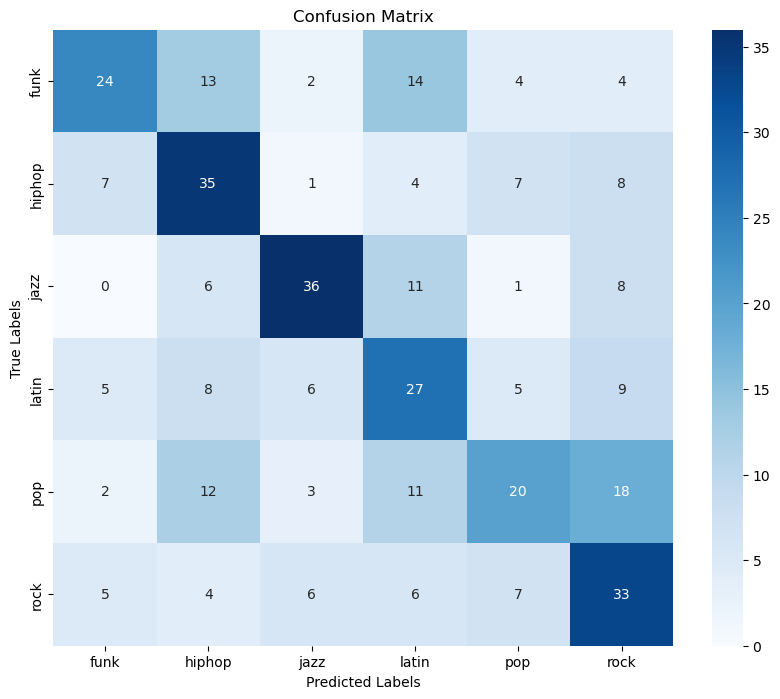

<Figure size 640x480 with 0 Axes>

In [91]:
report, h_loss = evaluate_model2(y_test, y_pred)
save_evaluation(report, h_loss, file_suffix=FILE_SUFFIX)

#### SHAP

https://stackoverflow.com/questions/65549588/shap-treeexplainer-for-randomforest-multiclass-what-is-shap-valuesi

In [93]:
label_encoder.classes_

array(['funk', 'hiphop', 'jazz', 'latin', 'pop', 'rock'], dtype=object)

In [111]:
import shap

explainer = shap.TreeExplainer(random_forest)
shap_values = np.array(explainer.shap_values(X_train))
print(shap_values.shape)

(828, 21, 6)


In [128]:
# I'm actually not 100% sure if shap_values_transposed[0] actually corresponds to the first class in the label_encoder.classes_ array after transposing 🤔
shap_values_transposed = shap_values.transpose((2,0,1))
shap_values_transposed.shape

(6, 828, 21)

##### FUNK feature importance

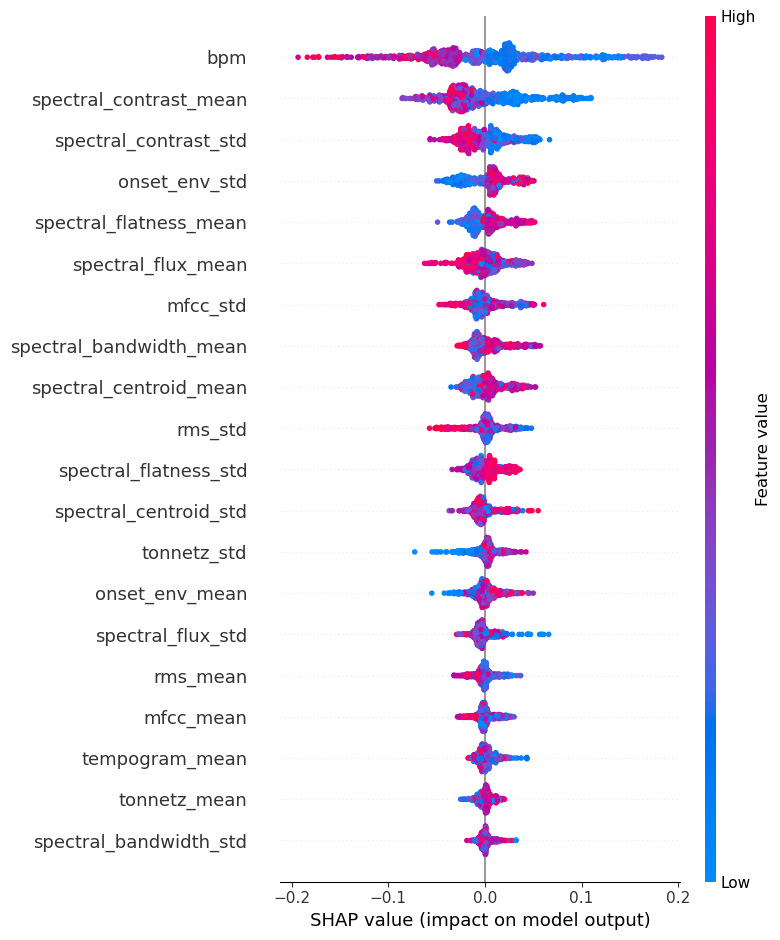

In [125]:
shap.summary_plot(shap_values_transposed[0], X_train)

#### HIP HOP feature importance

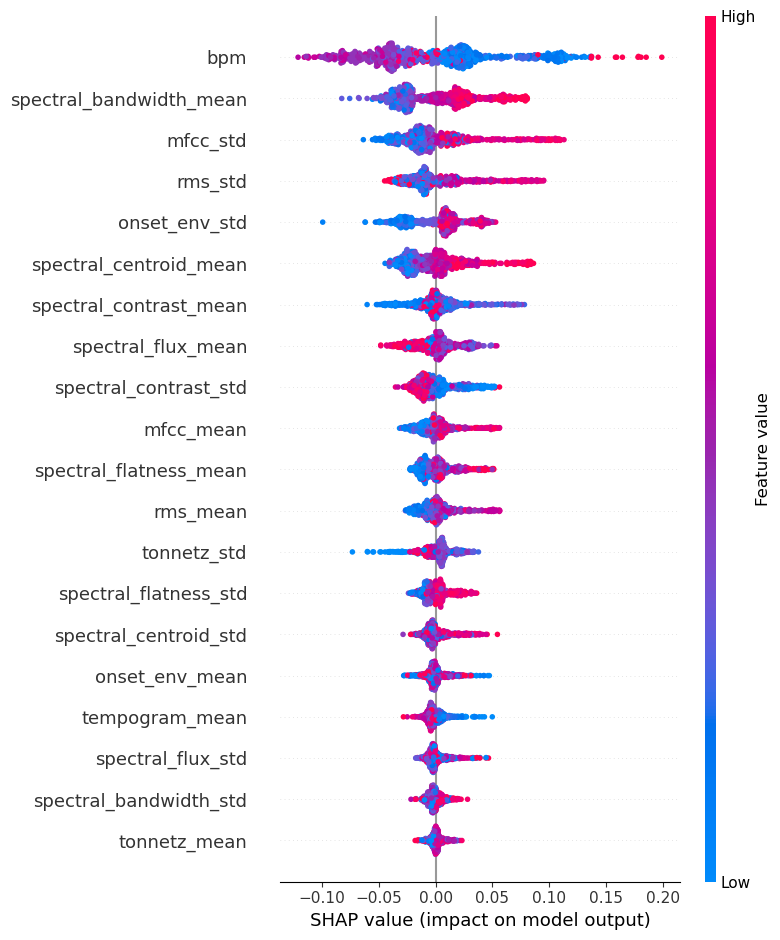

In [114]:
shap.summary_plot(shap_values_transposed[1], X_train)

#### JAZZ feature importance

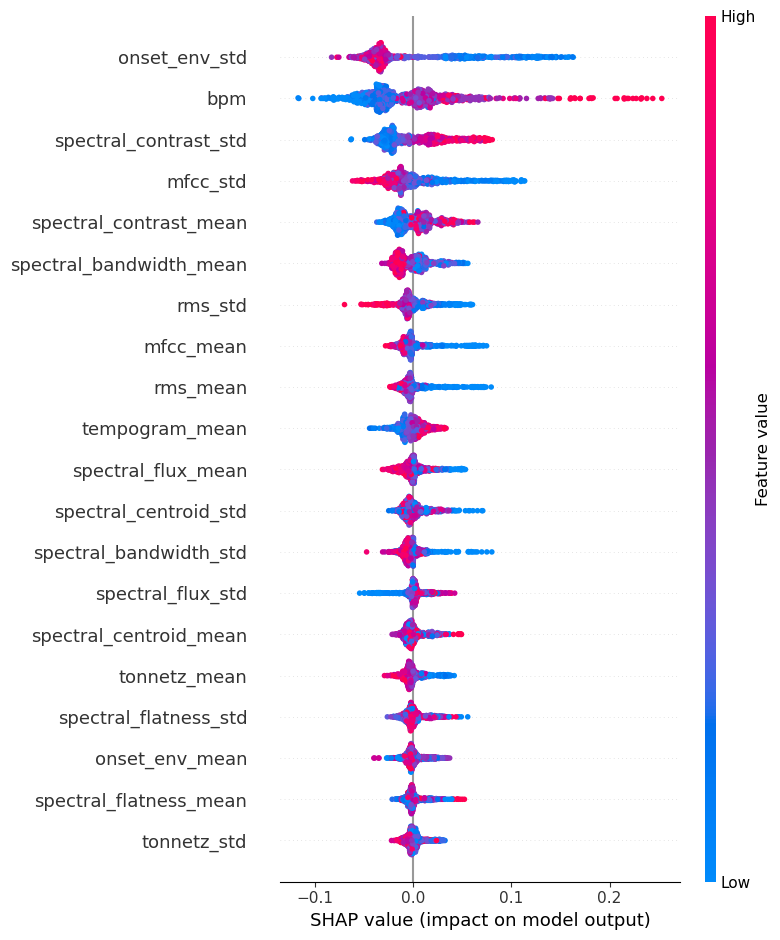

In [115]:
shap.summary_plot(shap_values_transposed[2], X_train)

#### LATIN feature importance

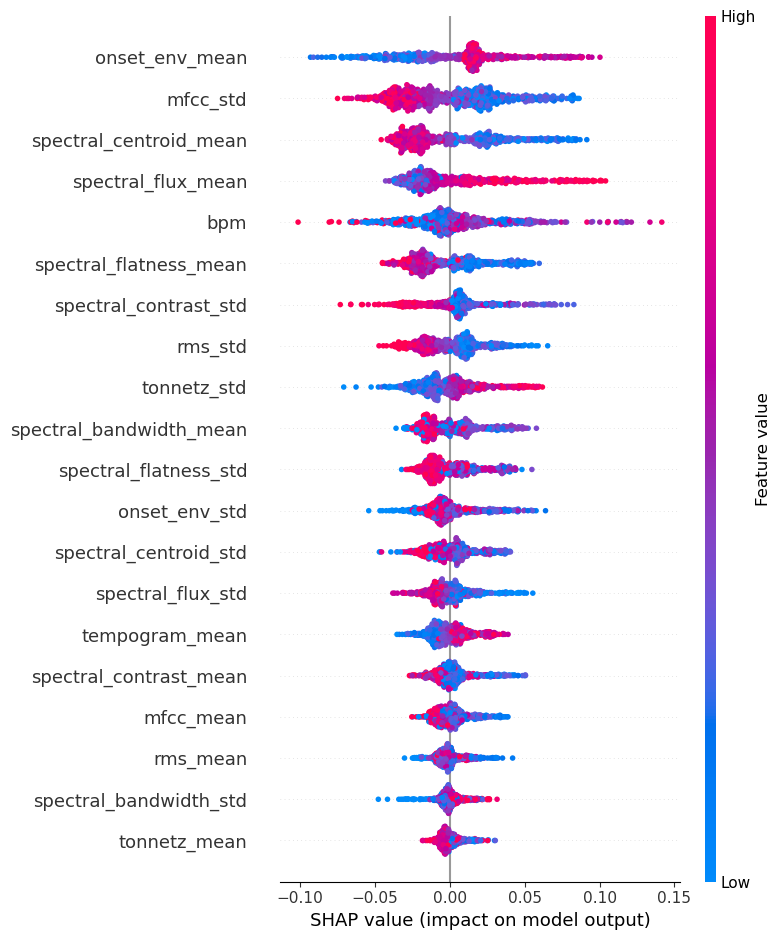

In [116]:
shap.summary_plot(shap_values_transposed[3], X_train)

#### POP feature importance

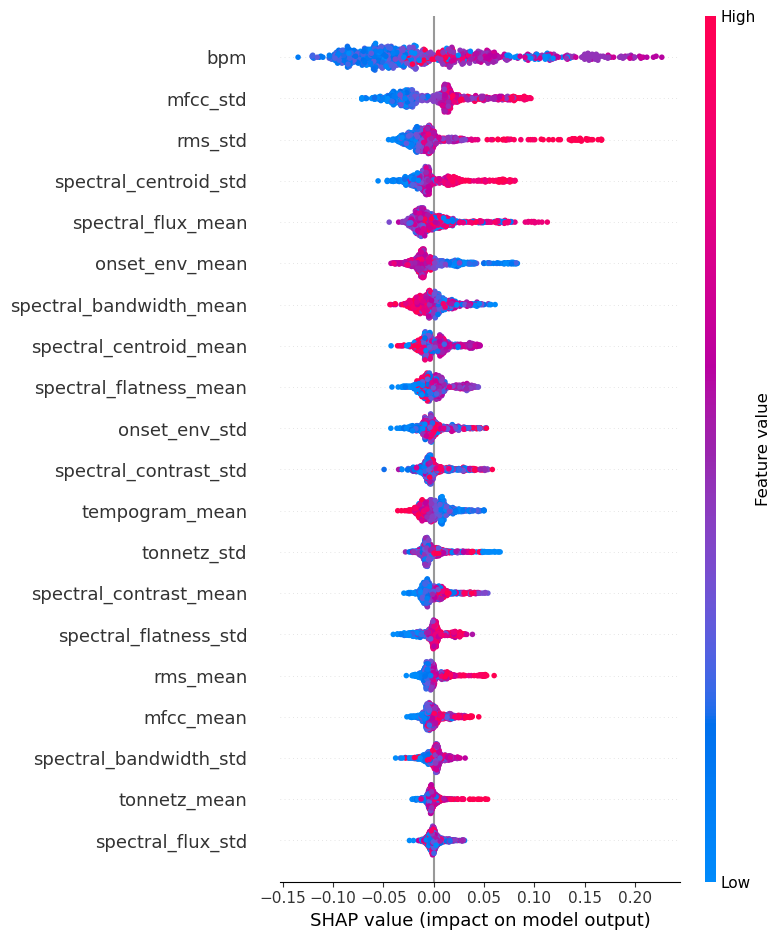

In [117]:
shap.summary_plot(shap_values_transposed[4], X_train)

#### ROCK feature importance

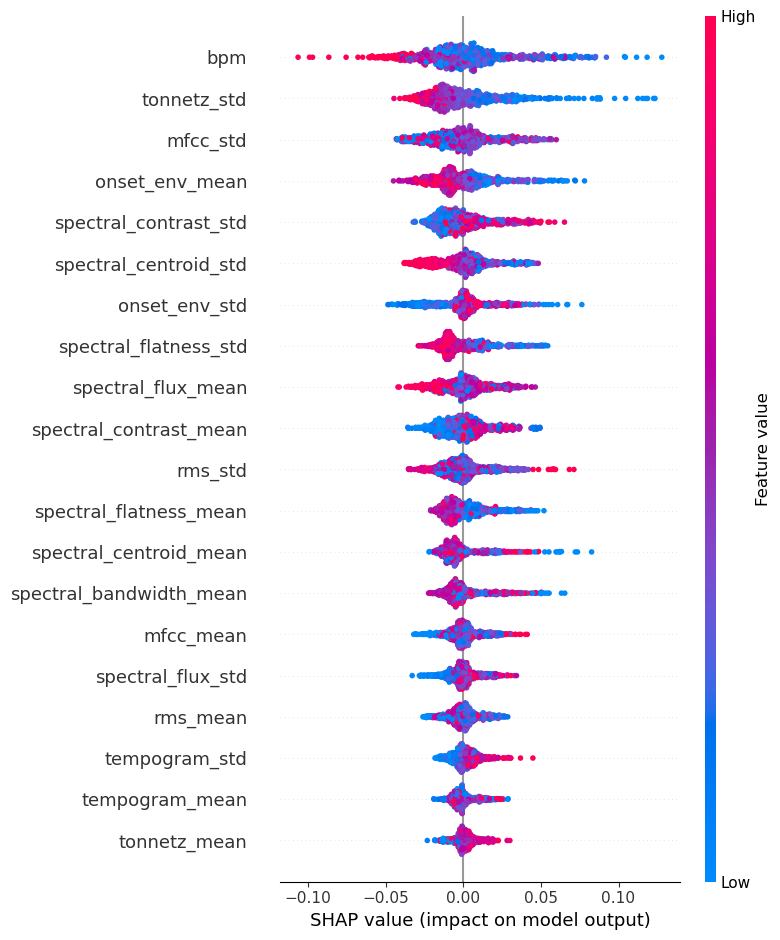

In [118]:
shap.summary_plot(shap_values_transposed[5], X_train)